# HPCA 2023 SupermarQ Tutorial

You can run this notebook on our [JupyterHub](https://hub.super.tech/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FSupertechLabs%2FSupermarQ&urlpath=tree%2FSupermarQ%2Fexamples%2FSupermarQ_HPCA_Tutorial.ipynb&branch=main) or [Binder](https://mybinder.org/v2/gh/SupertechLabs/SupermarQ/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FSupertechLabs%252FSupermarQ%252Ftree%252Fmain%252Fexamples%26urlpath%3Dtree%252Fexamples%252FSupermarQ_HPCA_Tutorial.ipynb%26branch%3Dmain). The JupyterHub requires sign up while Binder does not.

In [1]:
import os
import cirq

import cirq_superstaq as css
import qiskit_superstaq as qss
import supermarq

## Basics:

### 1. Service / Provider creation

In [2]:
# Provide your api key to the Service using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.

# Submit cirq circuits via cirq-superstaq
service = css.Service()
print(service.get_balance())

$145.05


In [3]:
# Provide your api key to the Provider using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.

# Submit qiskit circuits via qiskit-superstaq
provider = qss.SuperstaqProvider()
print(provider.get_balance())

$145.05


In [4]:
# See which backends are available
service.get_targets()

{'compile-only': ['aqt_keysight_qpu', 'aqt_zurich_qpu', 'sandia_qscout_qpu'],
 'compile-and-run': ['ibmq_qasm_simulator',
  'ibmq_lima_qpu',
  'ibmq_belem_qpu',
  'ibmq_quito_qpu',
  'ibmq_statevector_simulator',
  'ibmq_mps_simulator',
  'ibmq_extended-stabilizer_simulator',
  'ibmq_stabilizer_simulator',
  'ibmq_jakarta_qpu',
  'ibmq_manila_qpu',
  'ibmq_lagos_qpu',
  'ibmq_nairobi_qpu',
  'ibmq_perth_qpu',
  'ibmq_guadalupe_qpu',
  'ionq_ion_qpu',
  'aws_sv1_simulator',
  'aws_tn1_simulator',
  'aws_dm1_simulator',
  'ss_unconstrained_simulator',
  'hqs_lt-s1-apival_qpu',
  'hqs_lt-s1_simulator',
  'hqs_lt-s1_qpu',
  'hqs_lt-s2_qpu',
  'ionq_ion_simulator']}

### 2. Benchmark instantiation
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

All of the benchmarks can be found in `supermarq/benchmarks/`.

Think about other circuits/benchmarks you would like to implement and run!

In [5]:
# Create your benchmark using cirq circuits
ghz = supermarq.ghz.GHZ(5)
print(ghz.circuit())

0: ───H───@───────────────M───
          │               │
1: ───────X───@───────────M───
              │           │
2: ───────────X───@───────M───
                  │       │
3: ───────────────X───@───M───
                      │   │
4: ───────────────────X───M───


In [6]:
# Create your benchmark using qiskit circuits
ghz_qiskit_circuit = supermarq.converters.cirq_to_qiskit(supermarq.ghz.GHZ(5).circuit())
ghz_qiskit_circuit.draw()

┌───┐          ┌─┐                      
 q_0: ┤ H ├──■───────┤M├──────────────────────
      └───┘┌─┴─┐     └╥┘     ┌─┐              
 q_1: ─────┤ X ├──■───╫──────┤M├──────────────
           └───┘┌─┴─┐ ║      └╥┘     ┌─┐      
 q_2: ──────────┤ X ├─╫───■───╫──────┤M├──────
                └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
 q_3: ────────────────╫─┤ X ├─╫───■───╫─┤M├───
                      ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
 q_4: ────────────────╫───────╫─┤ X ├─╫──╫─┤M├
                      ║       ║ └───┘ ║  ║ └╥┘
m0: 5/════════════════╩═══════╩═══════╩══╩══╩═
                      0       1       2  3  4

### 3. Circuit evaluation
The generated circuits can be evaluated on a backend using any compatible service: AWS Braket, IBM Qiskit, cirq-superstaq, qiskit-superstaq, etc.

In [7]:
job_css = service.create_job(
    ghz.circuit(), repetitions=1000, target="ss_unconstrained_simulator", method="dry-run"
)

In [8]:
backend = provider.get_backend("ss_unconstrained_simulator")
job_qss = backend.run(
    supermarq.converters.cirq_to_qiskit(ghz.circuit()), shots=1000, method="dry-run"
)

### 4. Compute the score
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

In [9]:
job_css.status()

'Done'

In [10]:
counts = job_css.counts()
print(counts)
score_css = ghz.score(counts)
print(score_css)

{'00000': 518, '11111': 482}
0.9996758949559204


In [11]:
job_qss.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
counts = job_qss.result().get_counts()
print(counts)
score_qss = ghz.score(counts)
print(score_qss)

{'00000': 501, '11111': 499}
0.999998999999


### 5. Visualize the results
The function in `supermarq/plotting.plot_results` produces a simple bar plot. Feel free to copy and paste that code here to generate more detailed figures.

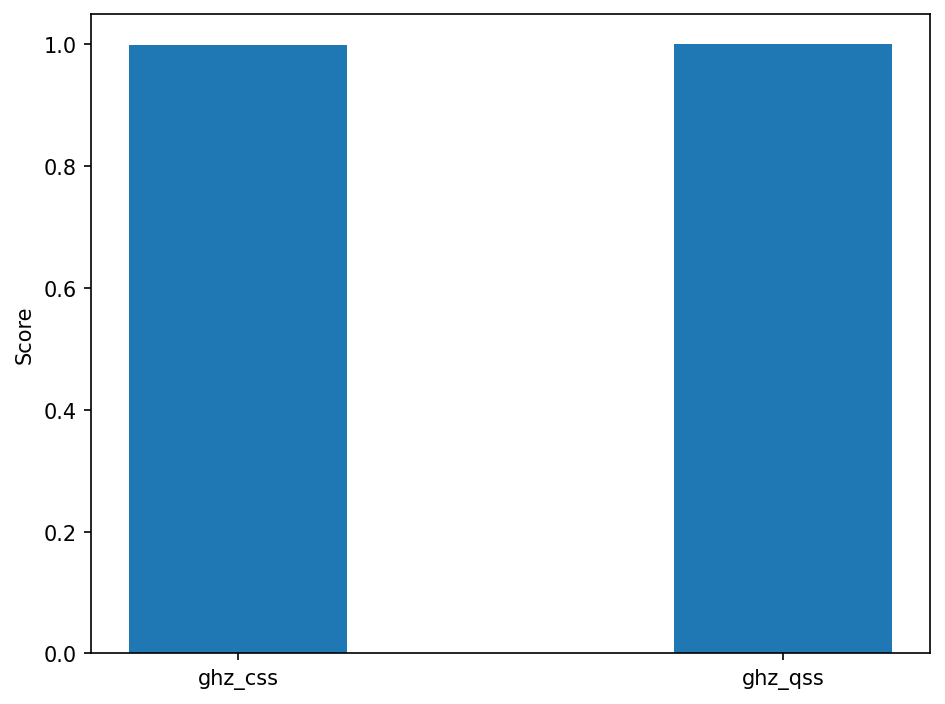

In [13]:
supermarq.plotting.plot_results([score_css, score_qss], ["ghz_css", "ghz_qss"])

## Quantum Program Profiling
The current hardware-agnostic application features can be found in `supermarq/features.py`. Quantum program profiling is an exciting area of research that is just getting started -- what kinds of features would you find meaningful? Try implementing them!

### Compute features

In [14]:
ghz_circuit = supermarq.ghz.GHZ(10).circuit()
ghz_features = [
    supermarq.features.compute_communication(ghz_circuit),
    supermarq.features.compute_depth(ghz_circuit),
    supermarq.features.compute_entanglement(ghz_circuit),
    supermarq.features.compute_liveness(ghz_circuit),
    supermarq.features.compute_measurement(ghz_circuit),
    supermarq.features.compute_parallelism(ghz_circuit),
]
print(ghz_features)

[0.2, 1.0, 0.9, 0.2636363636363636, 0.0, 0]


### Visualize the feature vector

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


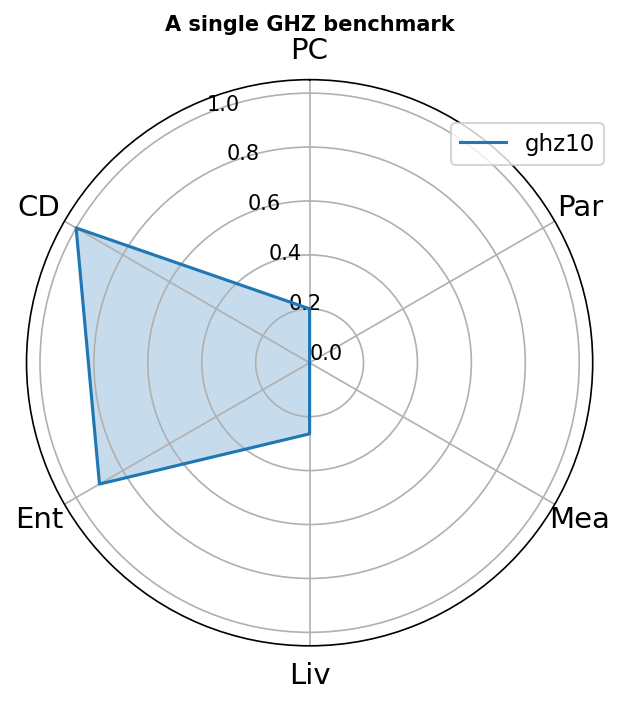

In [15]:
supermarq.plotting.plot_benchmark(
    ["A single GHZ benchmark", ["ghz10"], [ghz_features]],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

## Correlating performance <> features
To correlate the performance of a particular device with a certain application feature, it is helpful to evaluate several different benchmarks on that same device. This code example creates 4 different benchmarks, computes their feature vectors, evaluates them on a backend, and then measures the correlation between the performance seen and the application features.

### Characterize the benchmarks

In [16]:
benchmark_features = {}
benchmarks = [
    (supermarq.ghz.GHZ(5), "ghz5"),
    (supermarq.hamiltonian_simulation.HamiltonianSimulation(4), "hsim4"),
    (supermarq.mermin_bell.MerminBell(3), "mb3"),
    (supermarq.bit_code.BitCode(3, 3, [1, 0, 1]), "bitcode3"),
]
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.features.compute_communication(benchmark.circuit()),
        supermarq.features.compute_depth(benchmark.circuit()),
        supermarq.features.compute_entanglement(benchmark.circuit()),
        supermarq.features.compute_liveness(benchmark.circuit()),
        supermarq.features.compute_measurement(benchmark.circuit()),
        supermarq.features.compute_parallelism(benchmark.circuit()),
    ]
print(benchmark_features)

{'ghz5': [0.4, 1.0, 0.8, 0.4666666666666667, 0.0, 0], 'hsim4': [0.5, 1.0, 0.2857142857142857, 0.5961538461538461, 0.0, 0.38095238095238093], 'mb3': [1.0, 1.0, 0.4375, 0.6666666666666666, 0.0, 0.1875], 'bitcode3': [0.4, 0.5, 0.8571428571428571, 0.6142857142857143, 0.46153846153846156, 0.0]}


### Evaluate

In [17]:
jobs = []
for benchmark, label in benchmarks:
    job = service.create_job(
        circuit=benchmark.circuit(), repetitions=1000, target="ss_unconstrained_simulator"
    )
    jobs.append((label, job, benchmark))

### Wait until the benchmarks have successfully executed...

In [18]:
device_scores = {}
for label, job, benchmark in jobs:
    if job.status() == "Done":
        counts = job.counts()
        print(counts)
        score = benchmark.score(counts)
        print(score)
        device_scores[label] = score
    else:
        print(label, "not done!")

{'00000': 477, '11111': 523}
0.9994707198625362
{'0000': 2, '0001': 1, '0010': 4, '0011': 16, '0100': 4, '0101': 13, '0110': 17, '0111': 89, '1000': 3, '1001': 15, '1010': 16, '1011': 102, '1100': 17, '1101': 97, '1110': 100, '1111': 504}
0.9914466094067258
{'001': 1000}
1.0
{'11111110001': 1000}
1.0


### Measure the correlation between device performance and application features

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


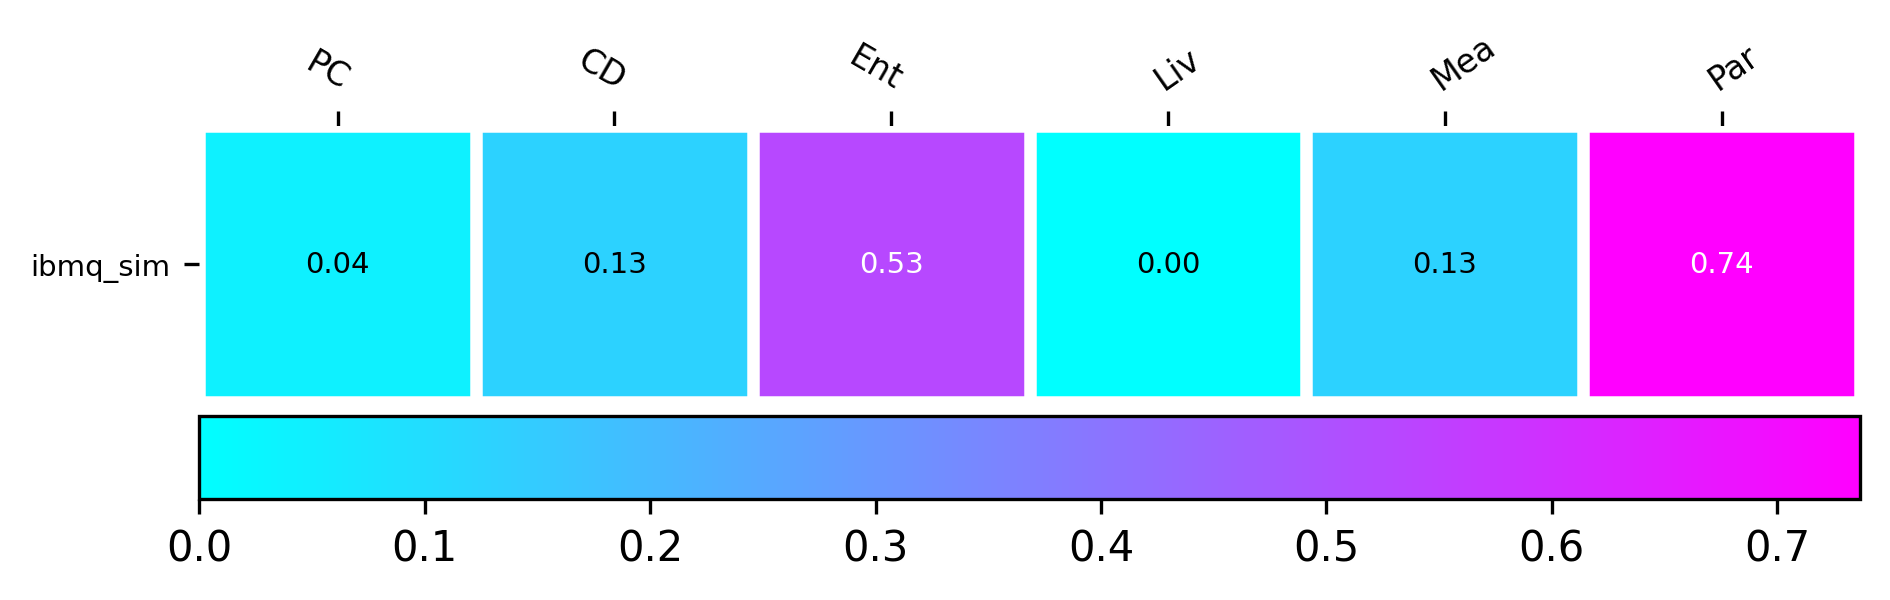

In [19]:
supermarq.plotting.plot_correlations(
    benchmark_features,
    device_scores,
    ["PC", "CD", "Ent", "Liv", "Mea", "Par"],
    device_name="ibmq_sim",
)